Environment and Libraries

In [1]:
#Libraries
import cv2
import os
import glob
import warnings
import scipy.misc
import numpy as np
import python_utilities
import python_utils
import labelme
import nibabel as nib
import torch
import transform
# # import nibabel as nib
import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt
import skimage
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
from matplotlib.widgets import Slider
import pydicom
import trimesh
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model

from scipy.spatial.distance import directed_hausdorff

from keras.callbacks import ModelCheckpoint

/Users/pranavrao/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Preprocessing Data

In [2]:
from preprocessing import preprocessing
import numpy as np
print('-'*30)
print('Loading and preprocessing training data...')
print('-'*30)

# \\files.auckland.ac.nz\research\resmed202100086-tws ----> Address for raw data
total_slices_raw_data = 1015
DataOnlyAOI = True
scans_path = '/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/MRI Scans - Tairawhiti'
segmasks_fnames = ['8_R_tibia_12A', '10_R_tibia_13A']
scan_data_folders = ['12A_AutoBindWATER_450', '13A_AutoBindWATER_450']

imgs_train, imgs_mask_train = preprocessing(scans_path, segmasks_fnames, scan_data_folders, total_slices_raw_data, DataOnlyAOI)

if (DataOnlyAOI == False):
    imgs_train = np.reshape(imgs_train, (len(scan_data_folders) * total_slices_raw_data, 512, 512))
    imgs_mask_train = np.reshape(imgs_mask_train, (len(segmasks_fnames) * total_slices_raw_data, 512, 512))
    imgs_train = np.expand_dims(imgs_train, axis=-1)
    imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)

if (DataOnlyAOI == True):
    imgs_train = np.expand_dims(imgs_train, axis=-1)
    imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)

print("\n")
print('Final Training Image Input Shape: ', imgs_train.shape)
print('Final Training Mask Input Shape: ', imgs_mask_train.shape)

print('-'*30)
print('Completed Preprocessing Stage!')
print('-'*30)

/Users/pranavrao/opt/anaconda3/lib/python3.9/site-packages/pyntcloud/utils/numba.py:5: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_count(xyz, indices, out):
/Users/pranavrao/opt/anaconda3/lib/python3.9/site-packages/pyntcloud/utils/numba.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_sum(xyz, indices, N, out):
/Users/pranavrao/opt

------------------------------
Loading and preprocessing training data...
------------------------------
Patient Scan Data Folders Included in Run:  ['12A_AutoBindWATER_450', '13A_AutoBindWATER_450']


Segmentation Mask:  8_R_tibia_12A
Patient Scan Data:  12A_AutoBindWATER_450
Height of Paitent in mm:  1523.5
Length of Paitent AOI (tibia) in mm:  306.723876953125
AOI Slice Start:  691
AOI Slice End:  894
AOI Slice Range:  204
Mask Slices Normalized to MRI Scans Shape (Purely AOI):  (204, 512, 512)




Segmentation Mask:  10_R_tibia_13A
Patient Scan Data:  13A_AutoBindWATER_450
Height of Paitent in mm:  1523.5
Length of Paitent AOI (tibia) in mm:  349.89306640625
AOI Slice Start:  768
AOI Slice End:  1001
AOI Slice Range:  234
Mask Slices Normalized to MRI Scans Shape (Purely AOI):  (234, 512, 512)


Number of Paitents:  438
Training Scans Input Shape:  (438, 512, 512)
Training Masks Input Shape:  (438, 512, 512)
Memory usage of training_scans: 438 MB.
Memory usage of train_mask_tibia_l

In [30]:
from preprocessing import read_dicom_files
from preprocessing import flatten_2d_array
from matplotlib.patches import Polygon
import matplotlib.path as mpath


def read_ply_file(ply_path):
    # Read the PLY file using trimesh
    mesh = trimesh.load(ply_path)
    # Extract the vertices and faces
    vertices = mesh.vertices
    faces = mesh.faces
    return vertices, faces, mesh

def clip_vertices(vertices, image_shape):
    vertices[:, 0] = np.clip(vertices[:, 0], 0, image_shape[1] - 1)
    vertices[:, 1] = np.clip(vertices[:, 1], 0, image_shape[0] - 1)
    return vertices

def project_vertices_to_image_plane(vertices, dicom_shape):
    # Get the scale factors to project 3D points to image plane
    scale_x = dicom_shape[1] / np.max(vertices[:, 0])
    scale_y = dicom_shape[0] / np.max(vertices[:, 1])

    # Project vertices to the image plane
    projected_vertices = vertices[:, :2] * [scale_x, scale_y]

    # Flip y-coordinates to align with image coordinates
    projected_vertices[:, 1] = dicom_shape[0] - projected_vertices[:, 1]

    return projected_vertices.astype(int)

def create_mask_from_faces(vertices, faces, dicom_shape):
    # Project vertices to the image plane
    projected_vertices = project_vertices_to_image_plane(vertices, dicom_shape)

    # Create empty mask
    mask = np.zeros(dicom_shape, dtype=np.uint8)

    # # Create a figure and axes
    # fig, ax = plt.subplots()

    # # Rasterize each face and fill the mask
    # for face in faces:
    #     face_vertices = projected_vertices[face, :]
    #     poly = Polygon(face_vertices, edgecolor='none', facecolor = "blue")
    #     ax.add_patch(poly)

    # ax.set_xlim(0, dicom_shape[1])
    # ax.set_ylim(dicom_shape[0], 0)
    # ax.axis('off')

    # # Draw the mask
    # fig.canvas.draw()
    # data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    # data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    # mask = (data[:, :, 0] > 0).astype(np.uint8)

    # plt.close(fig)


    #quicker implementation 
    # Rasterize each face and fill the mask
    for face in faces:
        face_vertices = projected_vertices[face, :]
        path_data = np.vstack([face_vertices, face_vertices[0]])  # Close the polygon
        path = mpath.Path(path_data)
        x, y = np.meshgrid(np.arange(dicom_shape[1]), np.arange(dicom_shape[0]))
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x, y)).T
        mask_values = path.contains_points(points).reshape(dicom_shape)
        mask[mask_values] = 1

    return mask

def preprocess_data(dicom_path, ply_path):
    # Pixel Data
    scan_pixel_data = []
    single_scan_pixel_data = []
    # Read DICOM file and PLY file
    dicom_files = read_dicom_files(dicom_path)

    # D:\MRI - Tairawhiti\AutoBind_WaterWATER_450
    for i in range (len(dicom_files)):
        single_scan_pixel_data.append(dicom_files[i].pixel_array)
    scan_pixel_data.append(single_scan_pixel_data)

    training_scans = flatten_2d_array(scan_pixel_data)
    dicom_image = np.array(training_scans)
    
    vertices, faces = read_ply_file(ply_path)
    # Convert 3D faces to 2D masks for each image slice
    masks = []
    for z in range(dicom_image.shape[0]):
        mask_slice = create_mask_from_faces(vertices, faces, dicom_image.shape[1:])
        masks.append(mask_slice)

    masks = np.stack(masks, axis=0)

    return dicom_image, masks

def preprocess_data_updated(dicom_path):
    # Pixel Data
    scan_pixel_data = []
    single_scan_pixel_data = []
    # Read DICOM file and PLY file
    dicom_files = read_dicom_files(dicom_path)

    # D:\MRI - Tairawhiti\AutoBind_WaterWATER_450
    for i in range (len(dicom_files)):
        single_scan_pixel_data.append(dicom_files[i].pixel_array)
    scan_pixel_data.append(single_scan_pixel_data)

    training_scans = flatten_2d_array(scan_pixel_data)
    dicom_image = np.array(training_scans)

    vertices, faces, mesh = read_ply_file(ply_path)
    # Convert 3D faces to 2D masks for each image slice
    masks = []

    return dicom_image





dicom_path = "/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/MRI Scans - Tairawhiti/12A_AutoBindWATER_450"
ply_path = '/Users/pranavrao/Documents/GitHub/Part4Project/SegmentationMasks/8_R_tibia_12A.ply'

dicom_image, masks = preprocess_data(dicom_path, ply_path)
seg_masks_15A_tibia = nib.load('/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/Mask_exports/8_R_tibia_12A.nii')
seg_masks_15A_tibia_data = seg_masks_15A_tibia.get_fdata()
seg_masks_15A_tibia_data = seg_masks_15A_tibia_data[:, :, ::-1]




def superimpose_images(image1, image2):
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)
    alpha = 0.5
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

slice = 750

image1 = np.expand_dims(dicom_image[slice,:,:], axis=-1)
image2 = np.expand_dims(seg_masks_15A_tibia_data[:,:,slice], axis=-1)

superimposed_image = superimpose_images(image1, image2)
plt.imshow(image1, cmap='gray')
plt.title('Superimposed')
plt.axis('on')
plt.show()

plt.imshow(image2, cmap='gray')
plt.title('Superimposed')
plt.axis('on')
plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
def visualize_dicom_and_masks(dicom_image, masks):
    num_slices = dicom_image.shape[0]

    # Plot DICOM images and corresponding masks side by side
    fig, axes = plt.subplots(nrows=num_slices, ncols=2, figsize=(10, 5 * num_slices))
    
    for i in range(num_slices):
        # Plot DICOM image
        axes[i, 0].imshow(dicom_image[i], cmap='gray')
        axes[i, 0].set_title(f"DICOM Slice {i}")
        axes[i, 0].axis('off')

        # Plot mask
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask Slice {i}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


visualize_dicom_and_masks(dicom_image, masks)



Exporting out Labelled Datasets

In [10]:
# Exporting Training Scan and Mask Data
from writeout_dataset import WriteOutTextFile
from writeout_dataset import WriteOutImagePNGFiles

starting_slice = 1
save_directory_data_txt = '/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia'
save_directory_data_img = '/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/img/Data'
save_directory_mask_txt = '/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Masks_Tibia'
save_directory_mask_img = '/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/img/Masks'

WriteOutTextFile(imgs_train[:, :, :, 0], save_directory_data_txt, starting_slice)   
# WriteOutImagePNGFiles(imgs_train, save_directory_data_img)

WriteOutTextFile(imgs_mask_train[:, :, :, 0], save_directory_mask_txt, starting_slice)   
# WriteOutImagePNGFiles(imgs_mask_train, save_directory_mask_img)

Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_1.txt
Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_2.txt
Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_3.txt
Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_4.txt
Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_5.txt
Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_6.txt
Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_7.txt
Saved /Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4P

Data Validation (Visual Sanity Check)

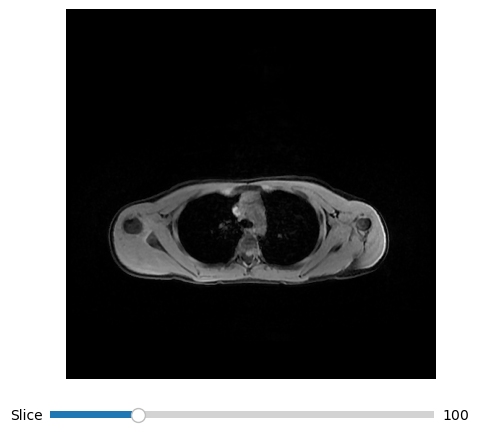

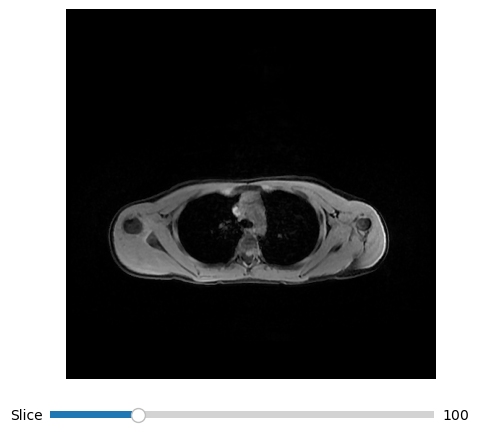

In [11]:
# Visualiser Tool Scan
temp = np.squeeze(imgs_train)
fig, ax = plt.subplots()
current_slice = 100
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

# Visualiser Tool Mask
# temp = np.squeeze(imgs_mask_train)
fig, ax = plt.subplots()
current_slice = 100
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

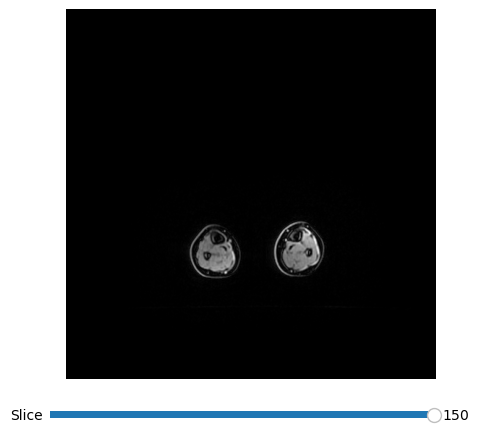

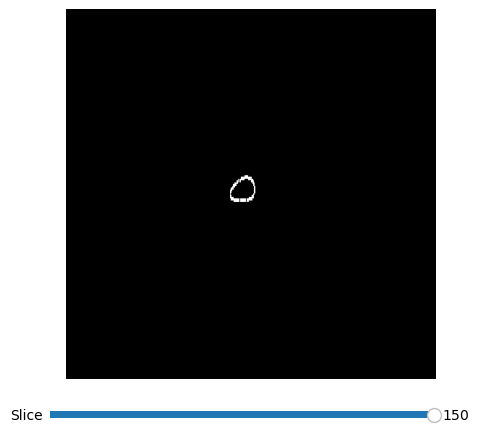

In [13]:
temp = np.loadtxt("/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia/data_100.txt", delimiter=',')
# Visualiser Tool Data Files

fig, ax = plt.subplots()
current_slice = 150
img = ax.imshow(temp, cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, current_slice, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

temp = np.loadtxt("/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Masks_Tibia/data_100.txt", delimiter=',')
# Visualiser Tool Data Files

fig, ax = plt.subplots()
current_slice = 150
img = ax.imshow(temp, cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, current_slice, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

2DUNet Model

In [19]:
# Define U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [14]:
from writeout_dataset import ReadInDatasets
imgs_train = ReadInDatasets('/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Data_Tibia')
imgs_mask_train = ReadInDatasets('/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/P4P Model Data/txt/Masks_Tibia')
# imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)
# imgs_train = np.expand_dims(imgs_train, axis=-1)

In [15]:
#from writeout_dataset import ReadInDatasets
#imgs_train = ReadInDatasets('D:/P4P Model Data/txt/Data_Tibia')
#imgs_mask_train = ReadInDatasets('D:/P4P Model Data/txt/Masks_Tibia')
imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)
imgs_train = np.expand_dims(imgs_train, axis=-1)

# Image Parameters
IMAGE_WDITH = 512
IMAGE_HEIGHT = 512
IMAGE_CHANNELS = 1

# Training, Testing and Validation Parameters
# TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# VALIDATION_VOLUMES = [9]

# Hyperparameters
N_CLASSES = 2
N_INPUT_CHANNELS = 1
# PATCH_SIZE = (32, 32)
# PATCH_STRIDE = (32, 32)

# # Data Preparation Parameters
# CONTENT_THRESHOLD = 0.3 # To Get Rid of Useless Information in the Image

# Training Parameters
N_EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 3
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
# LOSS = 'categorical_crossentropy'
LOSS = 'binary_crossentropy'
dropout_rate = 0.40


print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

images_train, images_val, labels_train, labels_val = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=0)
print('Training Image Input Shape: ', images_train.shape)
print('Training Mask Input Shape: ', labels_train.shape)
print('Validation Image Input Shape: ', images_val.shape)
print('Validation Mask Input Shape: ', labels_val.shape)


print('-'*30)
print('Creating and compiling model...')
print('-'*30)

# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
#     tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
# ]

# unet = get_unet()
# unet.compile(optimizer=OPTIMISER, loss=LOSS)
# unet.fit(
#     x=images_train, 
#     y=labels_train,
#     validation_data=(images_val, labels_val),
#     batch_size=BATCH_SIZE,
#     epochs=N_EPOCHS,
#     callbacks=my_callbacks,
#     verbose=1)

# unet.summary()

# unet = get_unet()
# unet.compile(optimizer=OPTIMISER, loss=LOSS)
# unet.load_weights('model.h5')

# testing_scans_processed = images_train[0]
# testing_masks_processed = labels_train[0]
# testing_scans_processed = np.reshape(testing_scans_processed, (1, 512, 512, 1))
# testing_masks_processed = np.reshape(testing_masks_processed, (1, 512, 512, 1))

# # testing_labels_processed = tf.keras.utils.to_categorical(testing_masks_processed, num_classes=2, dtype='float32')

# print('Testing Image Input Shape: ',testing_scans_processed.shape)
# print('Testing Mask Input Shape:',testing_masks_processed.shape)

# prediction = unet.predict(x=testing_scans_processed)
# # prediction = np.argmax(prediction, axis=3)
# # prediction = np.reshape(prediction[0], (512, 512))

# # plt.imshow(prediction, cmap='gray')
# # plt.show()

------------------------------
Loading and preprocessing train data...
------------------------------
Training Image Input Shape:  (700, 512, 512, 1)
Training Mask Input Shape:  (700, 512, 512, 1)
Validation Image Input Shape:  (176, 512, 512, 1)
Validation Mask Input Shape:  (176, 512, 512, 1)
------------------------------
Creating and compiling model...
------------------------------


In [20]:
input_shape = (512,512,1)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')
# model.compile(optimizer='adam', loss=dice_loss)
checkpoint = ModelCheckpoint('model(loss=binary,batch_size=4,epochs=20,train_size=500,aoi=tibia).h5', monitor='val_loss', save_best_only=True, mode='min')
model.fit(x=images_train, y=labels_train, batch_size=4, epochs=20, validation_data=(images_val, labels_val), callbacks=[checkpoint])
model.summary()

Epoch 1/20


2023-07-17 16:44:33.455609: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  9/175 [>.............................] - ETA: 51:51 - loss: 0.3814

 10/175 [>.............................] - ETA: 52:10 - loss: 0.3434

In [ ]:
model = 'best_model.h5'
# model = 'model(loss=binary,batch_size=4,epochs=20,train_size=500,aoi=tibia).h5'

from writeout_dataset import ReadInDatasets
imgs_test = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)', 0, 13)
testing_scans_processed = np.reshape(imgs_test, (len(imgs_test), 512, 512, 1))
print('testing_masks_processed size: ', testing_scans_processed.shape)

def superimpose_images(image1, image2):
    # Normalize the image intensities
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)

    alpha = 0.5  # Opacity of raw scan
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

print('-'*30)
print(f'Prediction Made Using Weights From Model: {model}')
print('-'*30)

pred_img_idx = 3
print('Testing Image Input Shape: ',(np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1))).shape)

best_model = load_model(model)
prediction = best_model.predict(np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1)))
# print('Testing Image Input Shape: ',testing_scans_processed[pred_img_idx].shape)
print('Prediction Mask Shape: ', prediction.shape)
print('\n')

DSC = dice_coefficient((np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1))), prediction)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

fig, ax = plt.subplots()
ax.imshow(prediction[0, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Raw Segmentation Result')
plt.show()

fig, ax = plt.subplots()
ax.imshow(testing_scans_processed[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Raw Test Scan')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(testing_scans_processed[pred_img_idx, :, :, 0], prediction[0, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Prediction Mask')
plt.show()

In [17]:
# Dice Coefficient Loss Function
def dice_loss(y_true, y_pred):
    smooth = 1e-5  # Adding a small constant to avoid division by zero
    print(y_true.shape)
    print(y_pred.shape)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    print(intersection)
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - tf.reduce_mean(dice_coefficient)
    return loss

In [6]:
# Flatten the array to 2D
flattened_array = imgs_train.reshape((imgs_train.shape[0], -1))

# Write the array to the text file
# np.savetxt('D:/P4P Model Data/txt/DataCompiled', flattened_array)

In [7]:
flattened_array.shape

(2134, 262144)

In [88]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

def assd(y_true, y_pred, spacing):
    surface_distances = surface_distance(y_true, y_pred, spacing)
    avg_surface_distance = np.mean(surface_distances)
    return avg_surface_distance

def surface_distance(y_true, y_pred, spacing):
    true_surface = find_surface_points(y_true, spacing)
    pred_surface = find_surface_points(y_pred, spacing)
    
    if true_surface.shape[0] == 0 or pred_surface.shape[0] == 0:
        raise ValueError("One or both surface point arrays are empty.")
    
    try:
        surface_distances_true_to_pred = directed_hausdorff(true_surface, pred_surface)[0]
        surface_distances_pred_to_true = directed_hausdorff(pred_surface, true_surface)[0]
        surface_distances = np.concatenate([surface_distances_true_to_pred, surface_distances_pred_to_true])
    except ValueError as e:
        print("Error occurred during Hausdorff distance calculation:", e)
        raise
    
    return surface_distances

def find_surface_points(mask, spacing):
    mask_padded = np.pad(mask, 1, mode='constant')
    mask_padded_diff = np.diff(mask_padded.astype(int), axis=0)
    
    surface_points = []
    for z in range(mask_padded_diff.shape[0]):
        surface_indices = np.where(mask_padded_diff[z] != 0)
        if len(surface_indices[0]) > 0:
            surface_points.extend(list(zip(surface_indices[0], surface_indices[1])))
    
    surface_points = np.array(surface_points)
    surface_points_phys = surface_points * spacing
    
    return surface_points_phys

def volume_error(y_true, y_pred):
    true_volume = np.sum(y_true)
    pred_volume = np.sum(y_pred)
    volume_error = np.abs(true_volume - pred_volume) / true_volume
    return volume_error


DSC = dice_coefficient(testing_masks_processed, prediction)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

# VError = volume_error(testing_masks_processed, prediction)
# print('Volume Error (VError) Metric Value: ', VError)
# print('\n')

# spacing = 1
# ASSD = assd(testing_masks_processed, prediction, spacing)
# print('Average Symmetric Surface Distance (ASSD) Metric Value: ', ASSD)
# print('\n')

Dice Similarity Coefficient (DSC) Metric Value:  [4.0989216e-06]




In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
# from keras.layers.core import Dropout
# import tensorflow as tf
# # from tensorflow.keras.models import Model
# from keras.layers import *
# from keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define U-Net model
# def unet_model(input_shape):
#     inputs = Input(input_shape)
    
#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
#     # Bottleneck
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)
    
#     # Decoder
#     up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
#     up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
#     up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
#     up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model

# # Dice Coefficient Loss Function 
# def dice_coefficient(y_true, y_pred):
#     smooth = 1e-5
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice


# # Reformat image data structure
# training_scans_reshaped = np.concatenate(preprocessed_images, axis=0)
# training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
# train_mask_tibia_labels_reshaped = np.concatenate(preprocessed_masks, axis=0)
# train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# # Split the data into training and validation sets\
# images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
# unseen_scan_model = np.array(training_scans[2][100])
# images_train = images_train.astype('float32') / 255.0
# images_val = images_val.astype('float32') / 255.0

# print(images_train.shape)
# print(labels_train.shape)
# print(images_train.dtype)
# print(labels_train.dtype)
# print(images_val.shape)
# print(labels_val.shape)
# print(images_val.dtype)
# print(labels_val.dtype)
# print(unseen_scan_model.shape)

# # Expand dimensions for the channel (grayscale) dimension
# # images_train = np.expand_dims(images_train, axis=-1)
# # images_val = np.expand_dims(images_val, axis=-1)
# # labels_train = np.expand_dims(labels_train, axis=-1)
# # labels_val = np.expand_dims(labels_val, axis=-1)

# # Create an instance of the U-Net model
# input_shape = (512, 512, 1)  # For grayscale images

# # Create an instance of the U-Net model
# model = unet_model(input_shape)

# # Compile the model
# # Binary Cross Entropy Loss Function
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Dice Coefficient Loss Function
# # model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# # Train the model
# # Hyperparameter tuning -> batch_size
# model.fit(x=images_train, y=labels_train, batch_size=32, epochs=1, validation_data=(images_val, labels_val))
# # Evaluate the model
# loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# # Perform inference on new, unseen MRI scans
# predictions = model.predict(unseen_scan_model)